In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

In [2]:
#reading in an image
def read_image(image_path):
    return mpimg.imread(image_path)

def write_image(image, path):
    plt.imsave(path, image)

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  

    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.

    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta_coeff, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.

    Returns an image with hough lines drawn.
    """
    theta = theta_coeff * np.pi/180
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img, lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.

    `initial_img` should be the image before any processing.

    The result image is computed as follows:

    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [4]:
def get_vertices(x, y, x_coeff, y_coeff, x_variant, y_variant):
    return np.array([[(x_variant+y_variant,x),(y*y_coeff-y_variant, x*x_coeff+x_variant),
                          (y*y_coeff+y_variant, x*x_coeff+x_variant), (y-y_coeff,x)]], dtype=np.int32) 

In [5]:
def extrapolated_lines(lines, image, max_vertical_slope, extrapolation_n):
    # 1.) Calculate slope of lanes m = y2-y1/x2-x1
    lines = np.squeeze(lines)
    slope = (lines[:,3]-lines[:,1]) / (lines[:,2] - lines[:,0])
    
    # 2.) Remove all Horzontal slopes from lines
    lines = lines[np.abs(slope)>max_vertical_slope]
    slope = slope[np.abs(slope)>max_vertical_slope]
    
    # 3.) Calculate line size of lanes length = √(x2-x1)2+(y2-y1)2
    line_size = np.sqrt((lines[:,2] - lines[:,0])**2 + (lines[:,3]-lines[:,1])**2)

    # 4.) Seperate positive and negative slopes lines and line sizes
    slope_pos, slope_neg = slope[slope>0], slope[slope<0]
    lines_pos, lines_neg = lines[slope>0,:], lines[slope<0,:]
    line_size_pos = line_size[slope>0]
    line_size_neg =  line_size[slope<0]
    
    # 5.) Sort line sizes to get the bigger ones in the end
    line_size_pos_sorted = np.argsort(line_size_pos)
    line_size_neg_sorted = np.argsort(line_size_neg)
    
    # 6.) Calculate average slope on the biggest n lines. n = extrapolation_n
    slope_pos_avg = slope_pos[line_size_pos_sorted][extrapolation_n::].mean()
    slope_neg_avg = slope_neg[line_size_neg_sorted][extrapolation_n::].mean()
    
    # 7.) Calculate y intercept c = y - m * x
    x_pos_vals = np.concatenate([lines_pos[:,0],lines_pos[:,2]])
    y_pos_vals = np.concatenate([lines_pos[:,1],lines_pos[:,3]])
    x_neg_vals = np.concatenate([lines_neg[:,0],lines_neg[:,2]])
    y_neg_vals = np.concatenate([lines_neg[:,1],lines_neg[:,3]])
    c_pos = y_pos_vals - (slope_pos_avg * x_pos_vals)
    c_neg = y_neg_vals - (slope_neg_avg * x_neg_vals)
    
    # 8.) Calculate average b again based on n biggest lines
    c_pos = c_pos[line_size_pos_sorted][extrapolation_n::]
    c_neg = c_neg[line_size_neg_sorted][extrapolation_n::]
    c_pos_avg = np.mean(c_pos)
    c_neg_avg = np.mean(c_neg)
    
    # 9.) Get y and x for left and right lane
    y1 = image.shape[0]
    x1_pos = (y1 - c_pos_avg) / slope_pos_avg
    x1_neg = (y1 - c_neg_avg) / slope_neg_avg

    y2 = image.shape[0]/1.5
    x2_pos = (y2 - c_pos_avg) / slope_pos_avg
    x2_neg = (y2 - c_neg_avg) / slope_neg_avg
    
    # 10.) Put points together as lane
    lines_connected = np.array([[[x1_pos,y1,x2_pos,y2],[x1_neg,y1,x2_neg,y2]]],dtype=np.int32)

    # 11.) Add lanes to image
    line_image = np.zeros_like(image)
    draw_lines(line_image, lines_connected, thickness=15)
    
    # 12.) Overlay image and lanes
    weighted_line_image = weighted_img(line_image, image)
    
    return weighted_line_image

In [6]:
param = {
    # blur parameters
    'kernel_size': 3, 

    # canny transform parameters
    'canny_low': 50, 
    'canny_high': 150, 

    # region of interest parameters
    'x_coeff': 0.5,
    'y_coeff': 0.5,
    'x_variant': 50,
    'y_variant': 25,

    # region of interest parameters
    'ax_coef': 0.4,
    'bx_coef': 0.6,
    'cy_coef': 0.6,
    'dy_coef': 0.6,
    'maxy_coef': 1.0,
    'maxx_coef': 1.0,
    'startx_coef': 0.0,

    # hough parameters
    'hough_rho': 2, 
    'hough_theta_coeff': 1, 
    'hough_threshold': 50, 
    'hough_min_line_length': 10, 
    'hough_max_line_gap': 20,
    
    # Extrapolation parameters
    'max_vertical_slope': 0.5,
    'extrapolation_n': -5

}

In [7]:
def pipeline(image=None, image_path=None, output_path = None, param = param):
    if image_path:
        # Read the image if there's a path
        image = read_image(image_path)
    if output_path:
        write_image(image, path = output_path + '-0-raw.png')
    
    # 
    blur_image = gaussian_blur(image, param['kernel_size'])
    if output_path:
        write_image(blur_image, path = output_path + '-1-gaussian-blur.png')
    
    edge_image = canny(blur_image, param['canny_low'], param['canny_high'])
    if output_path:
        write_image(edge_image, path = output_path + '-2-canny-edges.png')

    # 4.) Mask the image with fillPoly
    vertices =  get_vertices(image.shape[0], image.shape[1], param['x_coeff'], param['y_coeff'],
                                param['x_variant'], param['y_variant'])
                             
    roi_image = region_of_interest(edge_image, vertices=vertices)
    if output_path:
        write_image(roi_image, path = output_path + '-3-roi.png')
    
    # 5.) Perform hough transform and get line segments
    line_image, lines = hough_lines(roi_image, param['hough_rho'], param['hough_theta_coeff'], param['hough_threshold'], param['hough_min_line_length'], param['hough_max_line_gap'])
    if output_path:
        write_image(line_image, path = output_path + '-4-hough-lines.png')

    weighted_image = weighted_img(line_image, image)
    if output_path:
        write_image(weighted_image, path = output_path + '-5-weighted.png')
    
    extrapolated_weighted_image = extrapolated_lines(lines, image, param['max_vertical_slope'], param['extrapolation_n'])
    if output_path:
        write_image(extrapolated_weighted_image, path = output_path + '-6-extrapolated.png')
    return extrapolated_weighted_image

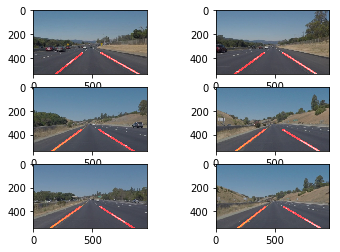

In [8]:
# Print out all the output for all the test images
plt.subplot(3,2,1)
plt.imshow(pipeline(image_path='test_images/solidWhiteCurve.jpg', output_path='test_images_output/A'))
plt.subplot(3,2,2)
plt.imshow(pipeline(image_path='test_images/solidWhiteRight.jpg', output_path='test_images_output/B'))
plt.subplot(3,2,3)
plt.imshow(pipeline(image_path='test_images/solidYellowCurve.jpg', output_path='test_images_output/C'))
plt.subplot(3,2,4)
plt.imshow(pipeline(image_path='test_images/solidYellowCurve2.jpg', output_path='test_images_output/D'))
plt.subplot(3,2,5)
plt.imshow(pipeline(image_path='test_images/solidYellowLeft.jpg', output_path='test_images_output/E'))
plt.subplot(3,2,6)
plt.imshow(pipeline(image_path='test_images/whiteCarLaneSwitch.jpg', output_path='test_images_output/F'))

In [9]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [10]:
def process_image(image):
    return pipeline(image=image)

In [11]:
white_output = 'test_videos_output/white.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/white.mp4
[MoviePy] Writing video test_videos_output/white.mp4


100%|█████████▉| 221/222 [00:03<00:00, 67.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/white.mp4 

CPU times: user 4.19 s, sys: 585 ms, total: 4.77 s
Wall time: 3.72 s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [13]:
yellow_output = 'test_videos_output/yellow.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/yellow.mp4
[MoviePy] Writing video test_videos_output/yellow.mp4


100%|█████████▉| 681/682 [00:12<00:00, 53.62it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/yellow.mp4 

CPU times: user 15.1 s, sys: 2.17 s, total: 17.3 s
Wall time: 13.1 s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

In [15]:
challenge_output = 'test_videos_output/extra.mp4'
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/extra.mp4
[MoviePy] Writing video test_videos_output/extra.mp4


100%|██████████| 251/251 [00:08<00:00, 31.75it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/extra.mp4 

CPU times: user 10 s, sys: 2.26 s, total: 12.3 s
Wall time: 9.58 s


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))